In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers

In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from absl import logging
from sklearn.cluster import KMeans
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [9]:
data = pd.read_csv('/content/drive/MyDrive/SummarizationData/Tweets.csv')
data

,Tweet:
0,Pi goes a long way at \n@NASA\n. It is used to...
1,While we're all in favor of a little extra pie...
2,Ready to take math to Mars and beyond on #PiD...
3,"Happy #PiDay! It’s March 14th, or 3.14 – also ..."
4,"When we look at a slice of the night sky, 𝞹 (o..."
5,"Pi takes us far in space exploration. In fact,..."
6,"""In May last year, I announced the creation of..."
7,"""When we launched the Solidarity Response Fund..."
8,"""The money collected will be used to suppress ..."
9,"""The plan calls for a total requirement of $1...."


In [10]:
#data preparation
data_nparray = np.array(data)
data_array = []
for tweet in data_nparray:
  data_array.append(tweet[0])

data_copy = data_array

In [23]:
final_data = []
for tweet in data_array:
  tweet = tweet.replace("@","")
  tweet = tweet.replace('"',"")
  tweet = tweet.replace("\n","")
  tweet = tweet.replace("#","")
  tweet = tweet.replace(":","")
  tweet = tweet.replace("...","")
  
  final_data.append(tweet)

In [12]:
#embedding data
emb_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [13]:
embedded_final = emb_model(np.array(final_data))
embedded_final

pca = PCA(2)
embedded_final_new = pca.fit_transform(embedded_final)

In [14]:
#clustering
cluster_method = KMeans(3, random_state=1)

final_clusters = cluster_method.fit_predict(embedded_final_new)
final_clusters_unique = np.unique(final_clusters)

labels = cluster_method.labels_

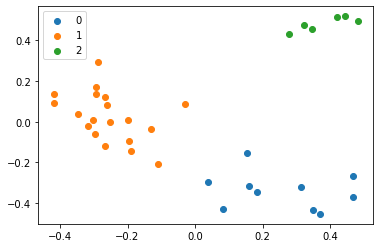

In [15]:
for i in final_clusters_unique:
  plt.scatter(embedded_final_new[final_clusters == i , 0] , embedded_final_new[final_clusters == i , 1] , label = i)
  
plt.legend()
plt.show()

In [ ]:
#preparation for TextRank Summarization
final = []
for tweet in final_data:
  tweet = tweet.replace(" ","")
  final.append(tweet)

In [ ]:
#TextRank implementation
!pip install transformers
!pip install sumy
!pip install sentencepiece
!pip install bert-extractive-summarizer 
from transformers import T5Tokenizer, T5ForConditionalGeneration
import re
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
import math
from sumy.summarizers import AbstractSummarizer
import numpy

In [73]:
class TextRankSummarizer(AbstractSummarizer):
  epsilon = 1e-4
  damping = 0.85
  _delta = 1e-7 
  _stop_words = frozenset()

  @property
  def stop_words(self):
    return self._stop_words

  @stop_words.setter
  def stop_words(self, words):
    self._stop_words = frozenset(map(self.normalize_word, words))

  @stop_words.setter
  def stop_words(self, words):
    self._stop_words = frozenset(map(self.normalize_word, words))

  def __call__(self, document, sentences_count):
    self._ensure_dependencies_installed()
    if not document.sentences:
      return ()
 
    ratings = self.rate_sentences(document)
    return self._get_best_sentences(document.sentences, sentences_count, ratings)

  @staticmethod
  def _ensure_dependencies_installed():
    if numpy is None:
      raise ValueError("LexRank summarizer requires NumPy. Please, install it by command 'pip install numpy'.")


  def _create_matrix(self, document):
    sentences_as_words = [self._to_words_set(sent) for sent in document.sentences]
    sentences_count = len(sentences_as_words)
    weights = numpy.zeros((sentences_count, sentences_count))

    for i, words_i in enumerate(sentences_as_words):
      for j, words_j in enumerate(sentences_as_words):
        weights[i, j] = self._rate_sentences_edge(words_i, words_j)

    weights /= (weights.sum(axis=1)[:, numpy.newaxis]+self._delta) 
    return numpy.full((sentences_count, sentences_count), (1.-self.damping) / sentences_count) + self.damping * weights

  def _to_words_set(self, sentence):
    words = map(self.normalize_word, sentence.words)
    return [self.stem_word(w) for w in words if w not in self._stop_words]

  def rate_sentences(self, document):
    matrix = self._create_matrix(document)
    ranks = self.power_method(matrix, self.epsilon) 
    return {sent: rank for sent, rank in zip(document.sentences, ranks)}

  @staticmethod
  def power_method(matrix, epsilon):
    transposed_matrix = matrix.T
    sentences_count = len(matrix)
    p_vector = numpy.array([1.0 / sentences_count] * sentences_count)
    lambda_val = 1.0

    while lambda_val > epsilon:
      next_p = numpy.dot(transposed_matrix, p_vector)
      lambda_val = numpy.linalg.norm(numpy.subtract(next_p, p_vector))
      p_vector = next_p

    return p_vector

  @staticmethod
  def _rate_sentences_edge(words1, words2):
    rank = 0
    for w1 in words1:
      for w2 in words2:
        rank += int(w1 == w2)

      if rank == 0:
        return 0.0

      assert len(words1) > 0 and len(words2) > 0
      norm = math.log(len(words1)) + math.log(len(words2))
      if numpy.isclose(norm, 0.):
            # This should only happen when words1 and words2 only have a single word. Thus, rank can only be 0 or 1.
        assert rank in (0, 1)
        return rank * 1.0
      else:
        return rank / norm

In [85]:
model = TextRankSummarizer()

words1 = final_data[11].split(" ")
words2 = final_data[11].split(" ")

model._rate_sentences_edge(words1, words2)

0.25694917118487537